## Building and training a CNN model

In [1]:
import sys
import os
import glob
import typing
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

# hint: notebook is executed in jupyter lab dark mode
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html for styles
# plt.style.use('dark_background')
# # global color settings (use white/grey for jupyterlab dark mode
# # and black/grey for jupyterlab light mode)
# COLOR = 'grey'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR
# # plt.rcParams['grid.color'] = COLOR
# # plt.rcParams['figure.edgecolor'] = 'red'
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

## the following code snippet is necessary for tensorflow 
## training to work (tf2.2, cuda10.2 or 10.1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

Using TensorFlow backend.


Python version: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
Numpy version: 1.18.1
Pandas version: 1.0.3
Tensorflow version: 2.2.0
Keras version: 2.3.1


## Data import and preprocessing:

In [2]:
## get data
df = pd.read_hdf('data_summary.hdf')
## convert class labels to string:
df['class_pneumonia'] = df['label_pneumonia'].astype('str')
df.head()

,iid,finding_labels,nr_follow_up,pid,patient_age,patient_gender,view_position,oimage_width,oimage_height,oimage_px_spacing_x,...,label_fibrosis,label_hernia,label_infiltration,label_mass,label_no_finding,label_nodule,label_pleural_thickening,label_pneumonia,label_pneumothorax,class_pneumonia
0,00000001_000.png,cardiomegaly,0,1,58,m,pa,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,cardiomegaly|emphysema,1,1,58,m,pa,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,cardiomegaly|effusion,2,1,58,m,pa,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,no_finding,0,2,81,m,pa,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,hernia,0,3,81,f,pa,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,0


## Training, validation and testing data

In [3]:
def create_splits(df, train_size: float=0.8, valid_size: float=0.1, test_size: float=0.1, random_state=None):
    """
    :param valid_size: relative size of validation dataset
    """
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    if 'pid' not in df:
        raise AttributeError("Feature 'pid' not available in df.")
    if 'label_pneumonia' not in df:
        raise AttributeError("Feature 'label_pneumonia' not available in df.")
    
    np.random.seed(seed=random_state)
    ## select all patients from the total dataset in random order
    pid_rand = np.random.choice(df['pid'].unique(), size=df['pid'].nunique(),
                                replace=False, p=None)
    pids_train = pid_rand[: int(df['pid'].nunique() * train_size)]
    pids_valid = pid_rand[int(df['pid'].nunique() * train_size): int(df['pid'].nunique() * (train_size + valid_size))]
    pids_test = pid_rand[int(df['pid'].nunique() * (train_size + valid_size)):]
    ## get training dataset:
    df_train = df[df['pid'].isin(pids_train)]
    ## get validation dataset
    df_valid = df[df['pid'].isin(pids_valid)]
    ## get test dataset
    df_test = df[df['pid'].isin(pids_test)]
    return df_train, df_valid, df_test


def balance_dataset(df: pd.DataFrame, col_label: str, random_state:typing.Union[None, int]=None) -> pd.DataFrame:
    """
    
    """
    ## create a balanced training dataset by randomly selecting 
    ## negative samples and discarding the remaining:
    nr_samples = df[col_label].value_counts().min()
    df1 = pd.DataFrame([])
    for label in df[col_label].unique():
        df1 = df1.append(df[df[col_label]==label].sample(nr_samples, random_state=random_state))
    return df1


def data_split_analysis(df: pd.DataFrame, df_train: pd.DataFrame, df_valid: pd.DataFrame,
                        df_test: pd.DataFrame, df_train_sample: pd.DataFrame) -> pd.DataFrame:
    """
    
    """
    df1 = pd.DataFrame(columns=['train', 'valid', 'test', 'train_sample', 'complete_dataset'])

    df1.loc['cardinality'] = [
        df_train.shape[0], df_valid.shape[0], df_test.shape[0],
        df_train_sample.shape[0], df.shape[0]]
    df1.loc['relative_cardinality'] = df1.loc['cardinality'] / df.shape[0]

    df1.loc['positie_samples'] = [
        df_train['label_pneumonia'].sum(), df_valid['label_pneumonia'].sum(),
        df_test['label_pneumonia'].sum(), df_train_sample['label_pneumonia'].sum(),
        df['label_pneumonia'].sum()
    ]
    df1.loc['negative_samples'] = df1.loc['cardinality'] - df1.loc['positie_samples']
    
    df1.loc['ratio_pos_neg_samples'] = (
        df1.loc['positie_samples'] / df1.loc['negative_samples']
    )

    df1.loc['age_mean'] = [
        df_train['patient_age'].mean(), df_valid['patient_age'].mean(),
        df_test['patient_age'].mean(), df_train_sample['patient_age'].mean(),
        df['patient_age'].mean()
    ]
    df1.loc['age_std'] = [
        df_train['patient_age'].std(), df_valid['patient_age'].std(),
        df_test['patient_age'].std(), df_train_sample['patient_age'].std(), 
        df['patient_age'].std()
    ]

    df1.loc['age_mean_positive_samples'] = [
        df_train.loc[df_train['label_pneumonia']==1, 'patient_age'].mean(),
        df_valid.loc[df_valid['label_pneumonia']==1, 'patient_age'].mean(),
        df_test.loc[df_test['label_pneumonia']==1, 'patient_age'].mean(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==1, 'patient_age'].mean(),
        df.loc[df['label_pneumonia']==1, 'patient_age'].mean()
    ]
    df1.loc['age_std_positive_samples'] = [
        df_train.loc[df_train['label_pneumonia']==1, 'patient_age'].std(),
        df_valid.loc[df_valid['label_pneumonia']==1, 'patient_age'].std(),
        df_test.loc[df_test['label_pneumonia']==1, 'patient_age'].std(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==1, 'patient_age'].std(),
        df.loc[df['label_pneumonia']==1, 'patient_age'].std()
    ]

    df1.loc['age_mean_negative_samples'] = [
        df_train.loc[df_train['label_pneumonia']==0, 'patient_age'].mean(),
        df_valid.loc[df_valid['label_pneumonia']==0, 'patient_age'].mean(),
        df_test.loc[df_test['label_pneumonia']==0, 'patient_age'].mean(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==0, 'patient_age'].mean(),
        df.loc[df['label_pneumonia']==0, 'patient_age'].mean()
    ]
    df1.loc['age_std_negative_samples'] = [
        df_train.loc[df_train['label_pneumonia']==0, 'patient_age'].std(),
        df_valid.loc[df_valid['label_pneumonia']==0, 'patient_age'].std(),
        df_test.loc[df_test['label_pneumonia']==0, 'patient_age'].std(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==0, 'patient_age'].std(),
        df.loc[df['label_pneumonia']==0, 'patient_age'].std()
    ]

    df1.loc['females'] = [
        (df_train['patient_gender']=='f').sum(), (df_valid['patient_gender']=='f').sum(),
        (df_test['patient_gender']=='f').sum(), (df_train_sample['patient_gender']=='f').sum(),
        (df['patient_gender']=='f').sum()
    ]
    df1.loc['females_relative'] = df1.loc['females'] / df1.loc['cardinality']

    df1.loc['males'] = [
        (df_train['patient_gender']=='m').sum(), (df_valid['patient_gender']=='m').sum(),
        (df_test['patient_gender']=='m').sum(), (df_train_sample['patient_gender']=='m').sum(),
        (df['patient_gender']=='m').sum()
    ]
    df1.loc['males_relative'] = df1.loc['males'] / df1.loc['cardinality']

    df1.loc['pa_position'] = [
        (df_train['view_position']=='pa').sum(), (df_valid['view_position']=='pa').sum(),
        (df_test['view_position']=='pa').sum(), (df_train_sample['view_position']=='pa').sum(),
        (df['view_position']=='pa').sum()
    ]
    df1.loc['pa_position_relative'] = df1.loc['pa_position'] / df1.loc['cardinality']

    df1.loc['ap_position'] = [
        (df_train['view_position']=='ap').sum(), (df_valid['view_position']=='ap').sum(),
        (df_test['view_position']=='ap').sum(), (df_train_sample['view_position']=='ap').sum(),
        (df['view_position']=='ap').sum()
    ]
    df1.loc['ap_position_relative'] = df1.loc['ap_position'] / df1.loc['cardinality']
    return df1

In [4]:
RANDOM_STATE = 256

In [5]:
df_train, df_valid, df_test = create_splits(df=df, train_size=0.8, valid_size=0.05, test_size=0.15, random_state=RANDOM_STATE)
# we remove some negative training samples to achieve balanced classes:
df_train = balance_dataset(df=df_train, col_label='label_pneumonia', random_state=RANDOM_STATE)
# randomly select a representative sample for standardization:
df_train_sample = df_train.sample(n=500, random_state=RANDOM_STATE)
data_split_analysis(df=df, df_train=df_train, df_valid=df_valid, df_test=df_test, df_train_sample=df_train_sample)

,train,valid,test,train_sample,complete_dataset
cardinality,2276,5443,16760,500,112104
relative_cardinality,0.0203026,0.0485531,0.149504,0.00446014,1
positie_samples,1138,60,232,232,1430
negative_samples,1138,5383,16528,268,110674
ratio_pos_neg_samples,1,0.0111462,0.0140368,0.865672,0.0129208
age_mean,46.0123,47.4492,46.7723,45.522,46.8726
age_std,17.0926,16.0457,16.657,17.6171,16.5982
age_mean_positive_samples,45.0949,43.1167,42.9914,44.0733,44.6706
age_std_positive_samples,17.3957,16.9717,18.9039,17.8422,17.6391
age_mean_negative_samples,46.9297,47.4975,46.8253,46.7761,46.901


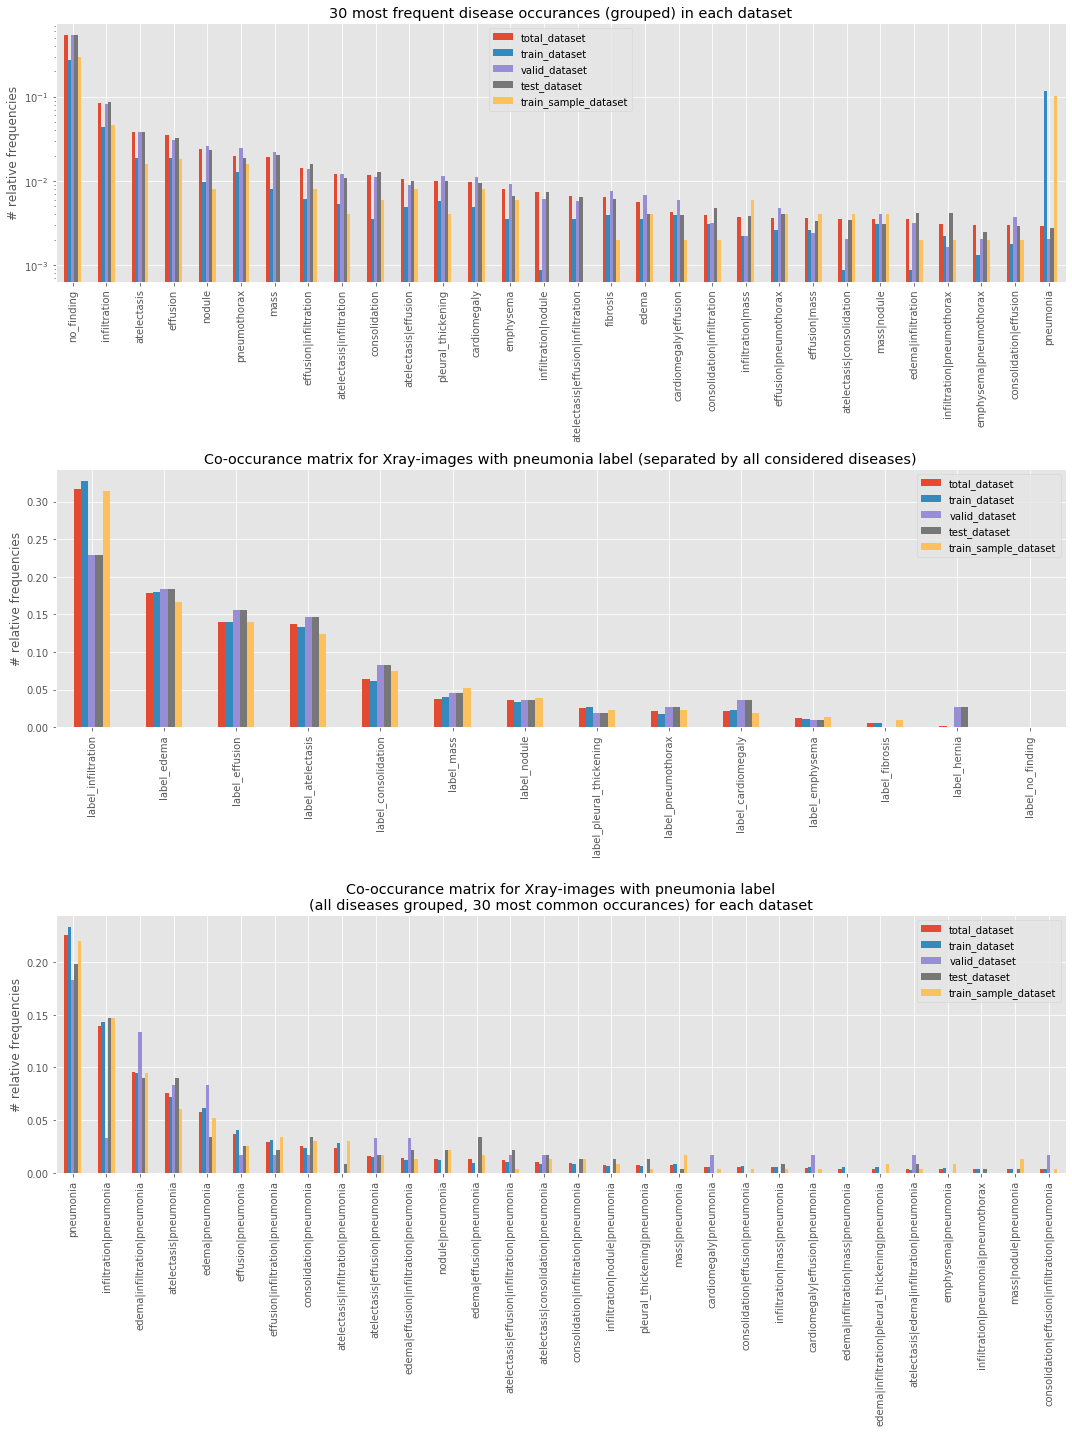

In [6]:
df_diseases = pd.DataFrame([])
df_diseases['total_dataset'] = df['finding_labels'].value_counts()
df_diseases['train_dataset'] = df_train['finding_labels'].value_counts()
df_diseases['valid_dataset'] = df_valid['finding_labels'].value_counts()
df_diseases['test_dataset'] = df_test['finding_labels'].value_counts()
df_diseases['train_sample_dataset'] = df_train_sample['finding_labels'].value_counts()
df_diseases_relative = df_diseases / df_diseases.sum()

dfa = pd.DataFrame([])
dfa['total_dataset'] = (
    df.loc[df['label_pneumonia']==1, df.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['train_dataset'] = (
    df_train.loc[df_train['label_pneumonia']==1, df_train.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['valid_dataset'] = (
    df_valid.loc[df_valid['label_pneumonia']==1, df_valid.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['test_dataset'] = (
    df_valid.loc[df_valid['label_pneumonia']==1, df_valid.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['train_sample_dataset'] = (
    df_train_sample.loc[df_train_sample['label_pneumonia']==1, df_train_sample.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)

dfa_relative = dfa / dfa.sum()

df_coocurrance = pd.DataFrame([])
df_coocurrance['total_dataset'] = df.loc[df['finding_labels'].str.contains('pneumonia'),
                                         'finding_labels'].value_counts()
df_coocurrance['train_dataset'] = df_train.loc[df_train['finding_labels'].str.contains('pneumonia'),
                                               'finding_labels'].value_counts()
df_coocurrance['valid_dataset'] = df_valid.loc[df_valid['finding_labels'].str.contains('pneumonia'),
                                               'finding_labels'].value_counts()
df_coocurrance['test_dataset'] = df_test.loc[df_test['finding_labels'].str.contains('pneumonia'),
                                             'finding_labels'].value_counts()
df_coocurrance['train_sample_dataset'] = df_train_sample.loc[df_train_sample['finding_labels'].str.contains('pneumonia'),
                                                             'finding_labels'].value_counts()
df_coocurrance_relative = df_coocurrance / df_coocurrance.sum()


fig, axarr = plt.subplots(3, 1, figsize=(15, 20))
ttl = '30 most frequent disease occurances (grouped) in each dataset'
df_diseases_relative[:30].plot.bar(ax=axarr[0], title=ttl, label='b', logy=True)
axarr[0].set_ylabel('# relative frequencies')

ttl = 'Co-occurance matrix for Xray-images with pneumonia label (separated by all considered diseases)'
dfa_relative.plot.bar(ax=axarr[1], title=ttl)
axarr[1].set_ylabel('# relative frequencies')

ttl = 'Co-occurance matrix for Xray-images with pneumonia label\n(all diseases grouped, 30 most common occurances) for each dataset'
df_coocurrance_relative.head(30).plot.bar(ax=axarr[2], title=ttl)
axarr[2].set_ylabel('# relative frequencies')
fig.tight_layout()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
sample_idg = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)
sample_gen = sample_idg.flow_from_dataframe(
    dataframe=df_train_sample, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    seed=RANDOM_STATE,
    batch_size=df_train_sample.shape[0],
    target_size=(1024, 1024)
)

a = sample_gen.next()
train_sample_mean = np.array([a[0][:,:, :, i].mean() for i in (0, 1, 2)])
train_sample_std = np.array([a[0][:,:, :, i].std() for i in (0, 1, 2)])
del a

Found 500 validated image filenames belonging to 2 classes.


/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
train_sample_std

array([63.483135, 63.483135, 63.483135], dtype=float32)

In [10]:
# use (224, 224, 3) for vgg16 model
IMG_SIZE = (224, 224)
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VALID = df_valid.shape[0]

In [11]:
## data augmentation on the training set:
train_idg = ImageDataGenerator(
    # use the following two arguments for standardization 
    featurewise_center=True,
    featurewise_std_normalization=True,
    ## use the rescale argument for scaling images:
#     rescale=1./255.0,
#     zca_whitening=False,
#     horizontal_flip = True, 
#     vertical_flip = False, 
#     height_shift_range= 0.1, 
#     width_shift_range=0.1, 
#     rotation_range=10, 
#     shear_range = 0.1,
#     zoom_range=0.1,
)
train_idg.mean = train_sample_mean
train_idg.std = train_sample_std

## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for training data:
train_gen = train_idg.flow_from_dataframe(
    dataframe=df_train, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=True,
    seed=RANDOM_STATE,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_TRAIN,
)

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(
    #rescale=1. / 255.0
)

## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for validation data:
val_gen = val_idg.flow_from_dataframe(
    dataframe=df_valid, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=True,
    seed=RANDOM_STATE,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_VALID
)

Found 2276 validated image filenames belonging to 2 classes.
Found 5443 validated image filenames belonging to 2 classes.


In [13]:
a = train_gen.next()

In [28]:
for i in range(16):
    print(a[0][i].std())

0.9442038
0.52367836
1.1323975
1.1182534
1.1559855
1.09802
0.014178452
0.8142594
0.8658101
0.8134053
1.1137539
1.0733418
1.0623977
0.81039304
0.8453585
0.678476


In [24]:
b = [
    0.5639238,
    -0.267339,
    0.30945092,
    -0.16166705,
    -0.1842851,
    0.26454908,
    1.5083462,
    0.49105877,
    -0.11076654,
    -0.088135906,
    -0.17491342,
    -0.26165265,
    -0.2170792,
    0.31342316,
    0.6742247,
    0.895215
]

In [26]:
sum(b)/16

0.22214704774999997

In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

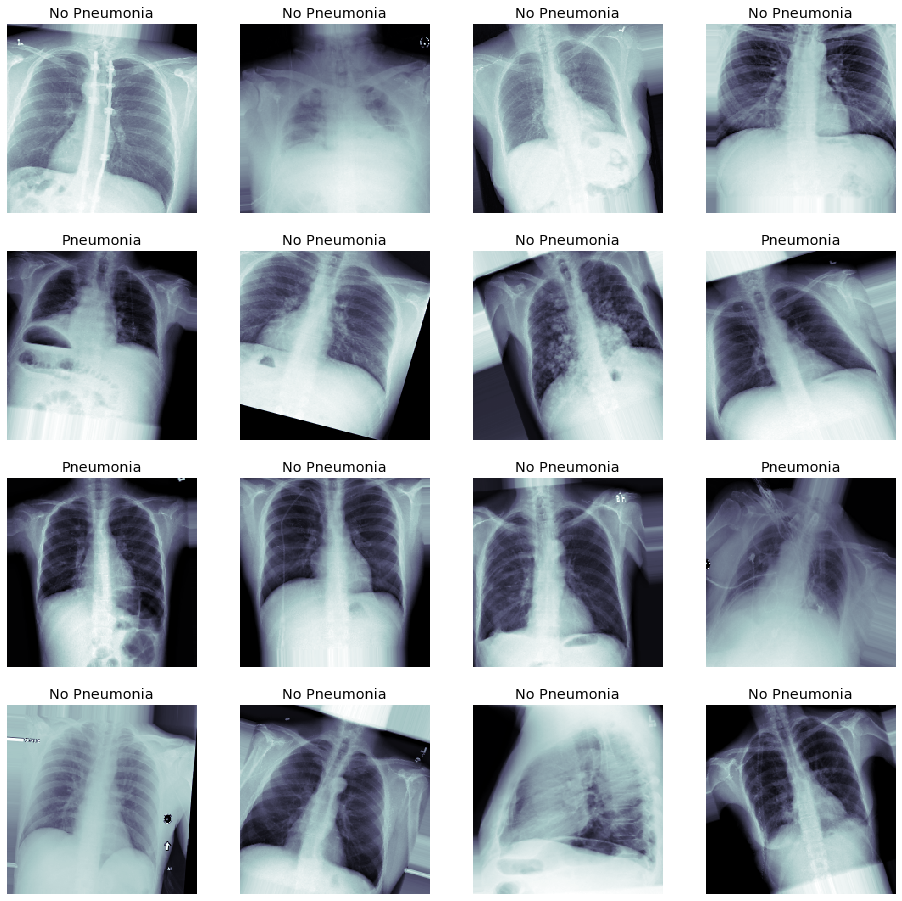

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model(model_architecture='vgg16'):
    """
    
    """
    if model_architecture.lower()=='vgg16':
        ## include_top: whether to include the 3 fully-connected layers at the top of the network.
        model = VGG16(include_top=True, weights='imagenet')
        ## create own model by removing last (dense) layers
        transfer_layer = model.get_layer('block5_pool')
        mdl = keras.models.Model(
            inputs=model.input,
            outputs=transfer_layer.output
        )
    else:
        raise NotImplementedError('Model has not been implemented yet')
    return mdl


def build_model(pretrained_model):
    """
    STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
    to output class activation maps to aid in clinical interpretation of your model's results
    """
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    model = keras.models.Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(pretrained_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(keras.layers.Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    model.add(keras.layers.Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(keras.layers.Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    model.add(keras.layers.Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(keras.layers.Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    model.add(keras.layers.Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(keras.layers.Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    model.add(keras.layers.Dense(1, activation='sigmoid'))    
    return model

In [12]:
model_pretrained = load_pretrained_model(model_architecture='vgg16')
model_pretrained.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in model_pretrained.layers[0:17]:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2


In [14]:
model_pretrained.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
model = build_model(pretrained_model=model_pretrained)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [17]:
INITIAL_LEARNING_RATE = 1e-3

In [18]:
## Set our optimizer, loss function, and learning rate
optimizer = keras.optimizers.Adam(lr=INITIAL_LEARNING_RATE)
loss = 'binary_crossentropy'
thresh = 0.5
metrics = [
    keras.metrics.BinaryAccuracy(name="binary_accuracy0_5", threshold=thresh),
    keras.metrics.Precision(thresholds=thresh, name='precision'),
    keras.metrics.Recall(thresholds=thresh, name='recall'),
    keras.metrics.TruePositives(thresholds=thresh, name='tp'),
    keras.metrics.TrueNegatives(thresholds=thresh, name='tn'),
    keras.metrics.FalsePositives(thresholds=thresh, name='fp'),
    keras.metrics.FalseNegatives(thresholds=thresh, name='fn'),
    keras.metrics.AUC(name='auc')
]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
## save model:
# create directory and subdirectories if they do not exist:
pth = 'data/models/'
os.makedirs(pth, exist_ok=True)
model.save(pth+'pneumonia_vgg16_model', overwrite=True, include_optimizer=True)
model.save(pth+'pneumonia_vgg16_model.h5', overwrite=True, include_optimizer=True)

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
dir_weights = 'data/models/weights/'
## create (sub-) directories if they do not exist:
os.makedirs(dir_weights, exist_ok=True)
## do not overwrite weights:
# path_weights = dir_weights + 'weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.hdf5'
## overwrite weights:
path_weights = dir_weights + 'weights.hdf5'

cb_save_weights = keras.callbacks.ModelCheckpoint(
    filepath=path_weights, 
    monitor='val_loss',
    mode='min',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

cb_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=12,
    restore_best_weights=True
)

cb_reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.2,
    patience=3,
    min_lr=1e-7)

lst_callbacks = [cb_save_weights, cb_early_stopping, cb_reduce_lr]

### Start training! 

In [21]:
EPOCHS = 10

In [ ]:
## train model:
history = model.fit(train_gen, 
                    validation_data=val_gen,
                    validation_freq=5,
                    epochs=EPOCHS,
                    callbacks=lst_callbacks)

Epoch 1/10
149/149 [==============================] - 614s 4s/step - loss: 0.6797 - binary_accuracy0_5: 0.5404 - precision: 0.6257 - recall: 0.2010 - tp: 239.0000 - tn: 1046.0000 - fp: 143.0000 - fn: 950.0000 - auc: 0.6094 - val_loss: 0.6041 - val_binary_accuracy0_5: 0.7861 - val_precision: 0.0166 - val_recall: 0.3154 - val_tp: 76.0000 - val_tn: 17105.0000 - val_fp: 4509.0000 - val_fn: 165.0000 - val_auc: 0.6027

Epoch 00001: val_loss did not improve from 0.48657
Epoch 2/10
148/149 [============================>.] - ETA: 0s - loss: 0.6793 - binary_accuracy0_5: 0.5436 - precision: 0.5448 - recall: 0.5301 - tp: 626.0000 - tn: 658.0000 - fp: 523.0000 - fn: 555.0000 - auc: 0.5863

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(path_weights)
pred_Y = model.predict(valX, batch_size=32, verbose=True)

16/16 [==============================] - 0s 6ms/step


In [25]:
pred_Y

array([[0.4939762 ],
       [0.48997265],
       [0.1949969 ],
       [0.40756994],
       [0.28808767],
       [0.48294833],
       [0.33062464],
       [0.40090597],
       [0.21521471],
       [0.47748277],
       [0.42483443],
       [0.33547944],
       [0.46478036],
       [0.29919672],
       [0.23876111],
       [0.48853335]], dtype=float32)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)